In [1]:
from qiskit import *
from qiskit import IBMQ, Aer

from qiskit.circuit import ParameterVector
from qiskit.visualization.bloch import Bloch
from qiskit.aqua.components.optimizers import SPSA
from qiskit.tools.monitor import job_monitor

import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np
import math
import time
import pickle
import random 
from random import randrange

In [2]:
qiskit.__qiskit_version__

{'qiskit-terra': '0.16.1',
 'qiskit-aer': '0.7.2',
 'qiskit-ignis': '0.5.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-aqua': '0.8.1',
 'qiskit': '0.23.2'}

In [3]:
IBMQ.load_account()

C:\Users\dado\anaconda3\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

#### Script parameters

In [4]:
quantum_hw = 0
bknd = 'ibmq_athens'
Shots = 8192                        #number of attempts for each measuration to get a statistical result
max_circuits_supported = 74         #use an number multiple of number_classes
layout = [0,1,2]

number_training = 50               #number of events of each type used during the training phase
number_testing = 2000              #number of events of each type used during the testing phase
SPSA_steps = 0                         #number of steps for SPSA algorithm (original: 100)
number_var = 3                      #total number of variables used to classify each event
number_classes = 2                  #number of classes for which classification is performed


#numbers associated to the variables used for the classification of each event (their order is relevant):
ii = 35
jj = 40
kk = 43


c_e_ii = 23.807574615434635
c_e_jj = 8.177020948034661
c_e_kk = 7.568297786037082


L1 = 1                 #Number of repetitions of the Mapping Circuit
L2 = 2                 #Number of repetitions of the Variational part of the Quantum Circuit


print_loss_func = 1     #1: prints the loss function evaluations, 0: doesn't
plot_AUC_image = 1      #1: prints the AUC graph, 0: doesn't
plot_data = 1           #1: prints the data images, 0: doesn't

#### Definitions of useful functions

In [5]:
def Cheb(x):
    return np.cos((x+1)*np.pi/2)

def InvCheb(x):
    return 2*np.arccos((x+1)/2)/np.pi-1

def Sqrt(x):
    x = np.clip(x,-1,1)
    return np.sqrt((x+1)/2)*2 -1

def InvSqrt(x):
    return ((x+1)**2 -1)/2

In [6]:
def f_label(i):
    if i%2==0:
        result = [1,0]
    else:
        result = [0,1]
    return result

In [7]:
def softmax_function(x):#IMPLEMENTED ONLY FOR 2 BITS
    F = [math.exp(x[0]),math.exp(x[1])]
    F = np.array(F)/sum(F)
    return F
  
#the following gives a two dimensional unitary vector obtained from results of measurations from the qubits     
def f_measuration(count):
    Z_m = np.zeros(2)
    for i in range(0,2**(number_bits)):
        for k in range(0,2):
            if eig[i][1-k] == '0' and eig[i] in count:
                Z_m[k] += count[eig[i]]  

    Z_m = (2*np.array(Z_m)-Shots)/Shots
    y = softmax_function(Z_m)
    return y

In [8]:
#definition of the mapping auxiliary function phi 
def Phi_function(x,y,z):
    return [np.arcsin(y),np.arccos(y**2),np.arcsin(x),np.arccos(x**2),np.arcsin(z),np.arccos(z**2)] 
    #the length of the array has to be equal to the number of qubits

In [9]:
def training_set(par,circuit,theta,Phi_f):
    
    #the following lines are destineted to the creation of the input for bind.parameters()
    pre_input = [[theta.params[k], par[k]] for k in range(0, number_parameters)]
    input_p2 = []
    for i in range(0,len(pre_input)):
        input_p2 = input_p2  + [pre_input[i][0]] + [pre_input[i][1]]
    the_input = [{Phi:Phi_f[i]} for i in range(0,len(X))]
    for i in range(0,len(X)):
        for j in range(0,len(pre_input)):
            the_input[i][pre_input[j][0]] = pre_input[j][1]
    
    #evaluation of the circuit with the parameters setted by the input, for all possible values in X
    Counts = []
    for j in range(0,N):
        circuits_dataset = [circuit.bind_parameters(the_input[i+j*max_circuits_supported]) for i in range(0,max_circuits_supported)]
        if quantum_hw:
            provider = IBMQ.get_provider('ibm-q')
            qcomp = provider.get_backend(bknd)
        else:
            qcomp = Aer.get_backend('qasm_simulator')
        job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
        job_monitor(job)
        result = job.result()
        counts = result.get_counts()
        Counts = Counts + counts
    
    circuits_dataset = [circuit.bind_parameters(the_input[i+max_circuits_supported*N]) for i in range(0,remainder)]
    if quantum_hw:
        provider = IBMQ.get_provider('ibm-q')
        qcomp = provider.get_backend(bknd)
    else:
        qcomp = Aer.get_backend('qasm_simulator')
    job = execute(circuits_dataset, backend = qcomp, optimization_level = 0, shots=Shots, initial_layout = layout)
    job_monitor(job)
    result = job.result()
    counts = result.get_counts()
    Counts = Counts + counts
    counts = Counts
    
    ### Just to check that the circuits look right...
    print(circuits_dataset[0].decompose())
    
    return counts

In [10]:
def plot_cost_fun(y):
    global iter_count
    global X_plot
    global Y_plot
    X_plot.append(iter_count)
    Y_plot.append(y)
    ax.clear()
    ax.plot(X_plot,Y_plot)
    fig.canvas.draw()
    iter_count += 1   
    
#Cost function is chosen as the Cross Entropy (except for an additive constant)

def cost_function(par,*args): #par will contain the parameters at each step of the optimization
    
    circuit = args[0]
    theta = args[1]
    Phi_f = args[2]
    
    counts = training_set(par,circuit,theta,Phi_f)

    L = 0
    print("\n current value of parameters: " , par )
        
    #estimated label 
    for i in range(0,len(X)):
        for k in range(0,2):
            yi = f_measuration(counts[i])
            L += -f_l[i][k]*math.log(yi[k])

#     if print_loss_func == 1:
#         plot_cost_fun(L)
    
    print("current value for loss function: " , L , "\n\n" )
    return L

#### Loading data for training

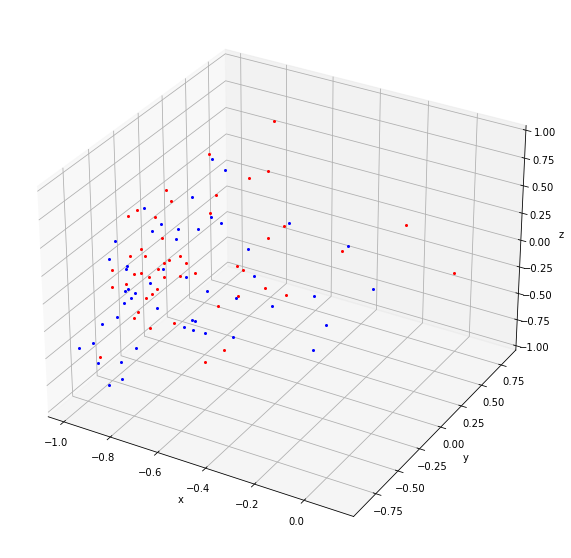

In [11]:
#DATA CAPTURE
#Here data are normalized in [-1,1] and, eventually, "stretched" or "squized" by using the previous functions.
#Odd and even elements of the following vectors will apparain to different classes (by choice)

data2 = pickle.load(open("background_balanced.pkl","rb"))
data1 = pickle.load(open("signal_balanced.pkl","rb"))
Ind = data1.columns
n = 0 #number_testing
start = randrange(8000)


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

XX = []
for i in range(start, start + number_training + n):
    XX.append(X1[i])
    XX.append(X2[i])

Xmax = max(max(XX),max(XX))
Xmin = min(min(XX),min(XX))

X = []
for i in range(0,number_training):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])

YY = []
for i in range(start, start + number_training + n):
    YY.append(Y1[i])
    YY.append(Y2[i])

Ymax = max(max(YY),max(YY))
Ymin = min(min(YY),min(YY))


Y = []
for i in range(0,number_training):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)  -1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

ZZ = []
for i in range(start, start + number_training + n):
    ZZ.append(Z1[i])
    ZZ.append(Z2[i])

Zmax = max(max(ZZ),max(ZZ))
Zmin = min(min(ZZ),min(ZZ))


Z = []
for i in range(0,number_training):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)  -1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)


X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])

#TRAINING SET VISUALIZATION
if plot_data == 1:
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 2)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 2)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')    

#### Preparing for the training

In [12]:
#this part of the program is needed in the case where there exists a maximal number of trainable circuits per-time
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [13]:
number_qubits = 1 #for EACH variable
number_bits = number_classes

#evaluation of phi
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i])[j]

In [14]:
#defining the label function for the trainingset, remember that odd and even events correspond to different classes

f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Build the variational circuit

In [15]:
number_parameters = 4*number_qubits*number_var

Phi = ParameterVector('Φ', 2*number_var) #int(number_qubits*(number_qubits+1)/2)
theta = ParameterVector('θ',number_parameters)

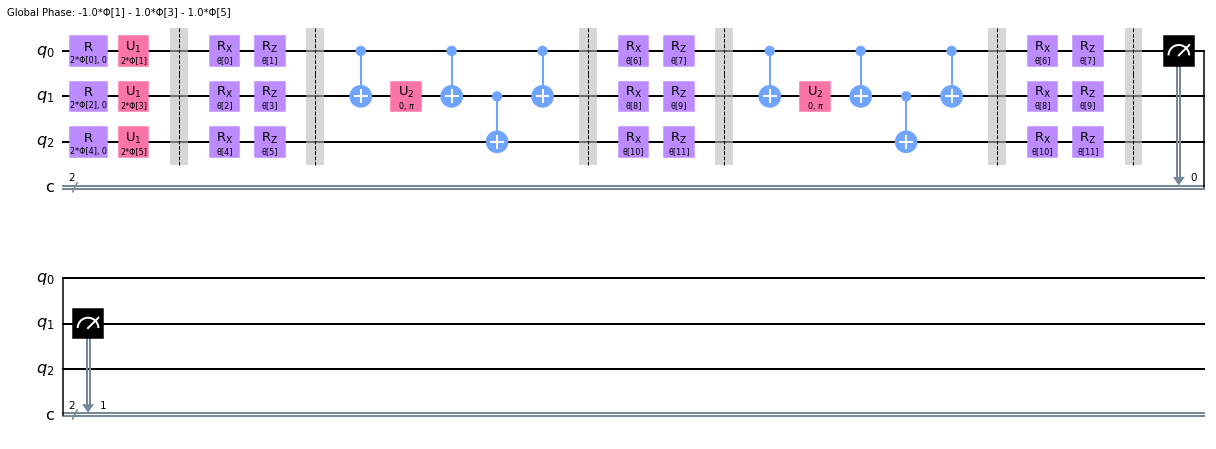

In [16]:
circuit = QuantumCircuit(number_var*number_qubits, number_bits)

for i in range(0,L1):

    for j in range(0,number_var):
        for k in range(0,number_qubits):
            circuit.rx(2*Phi[j*2],j+(number_var)*k)  
            circuit.rz(2*Phi[j*2+1],j+(number_var)*k) 
circuit.barrier()

#rotations
s = 0
for i in range(0,number_qubits*number_var):
    variational_circuit = QuantumCircuit(1)
    variational_circuit.rx(theta[s],0)
    s += 1
    variational_circuit.rz(theta[s],0)
    s += 1
    var_inst = variational_circuit.to_instruction()

    circuit.append(var_inst,[i])
circuit.barrier()
S = s

for k in range(0,L2):    
    #entanglement
    
    circuit.cx(0,1)
    circuit.h(1)
    circuit.cx(0,1)
    circuit.cx(1,2)
    circuit.cx(0,1)
    
    circuit.barrier()
    
    #rotations
    s = S
    for i in range(0,number_qubits*number_var):
        variational_circuit = QuantumCircuit(1)
        variational_circuit.rx(theta[s],0)
        s += 1
        variational_circuit.rz(theta[s],0)
        s += 1
        var_inst = variational_circuit.to_instruction()

        circuit.append(var_inst,[i])
    circuit.barrier()

    
circuit.measure(range(0,2),range(0,2))

decomposed_circuit = circuit.decompose()
decomposed_circuit.draw('mpl')

#### Training

In [17]:
factor = 100

#creation of the eigenstates list, i.e: ['000', '001',... ]
eig = []
for i in range(0,2**(number_bits)):
    eig.append('')

for j in range(0,number_bits):
    for i in range(0,2**j): 
        for k in range(0,(2**(number_bits-j))):            
            if (k % 2) == 0:
                eig[i+k*2**j] = '0' + eig[i+k*2**j] 
            else:
                eig[i+k*2**j] = '1' + eig[i+k*2**j]    

In [18]:
#initial values for parameters are chosen randomly
theta_0 = []
for i in range(0, number_parameters):
    theta_0.append(random.uniform(0, 2*np.pi))
theta_0 = np.array(theta_0)

#In the following c0 is the firt step "a", c1 is the initial "c", c2 is the "alpha" parameter, c3 the "gamma" parameter
#and finally c4 another parameter to control "a" (as like as "alpha" does)
t = time.time()

Optimizer = SPSA(max_trials = 1e3, save_steps = 1, last_avg = 1, c0 = 10/number_training, c1 = 0.3, c2 = 1, c3 = 0.7, c4 = 0, 
                 skip_calibration = False)

fw = Optimizer.wrap_function(cost_function,(circuit,theta,Phi_f))

cost_final, theta_best, cost_plus_save, cost_minus_save, theta_plus_save, theta_minus_save =  (
    Optimizer._optimization(fw,theta_0, SPSA_steps, save_steps = 1, last_avg = 3) )

print(cost_final,theta_best)

elapsed = time.time() - t
print(elapsed)

C:\Users\dado\anaconda3\lib\site-packages\qiskit\aqua\components\optimizers\spsa.py:93: DeprecationWarning: The max_trials parameter is deprecated as of 0.8.0 and will be removed no sooner than 3 months after the release. You should use maxiter instead.
  warnings.warn('The max_trials parameter is deprecated as of '


Job Status: job has successfully run
Job Status: job has successfully run
global phase: -3.34063545337588
     ┌─────────────────────────┐ ┌──────────────────────┐ ░ ┌─────────┐»
q_0: ┤ R(-0.306557125278507,0) ├─┤ U1(3.09496663248717) ├─░─┤ RX(0.0) ├»
     └┬────────────────────────┤┌┴──────────────────────┤ ░ ├─────────┤»
q_1: ─┤ R(-2.69845475837001,0) ├┤ U1(0.624105668577580) ├─░─┤ RX(0.0) ├»
     ┌┴────────────────────────┤└┬──────────────────────┤ ░ ├─────────┤»
q_2: ┤ R(-0.607904940605549,0) ├─┤ U1(2.96219860568700) ├─░─┤ RX(0.0) ├»
     └─────────────────────────┘ └──────────────────────┘ ░ └─────────┘»
c: 2/══════════════════════════════════════════════════════════════════»
                                                                       »
«     ┌─────────┐ ░                                 ░ ┌─────────┐┌─────────┐ ░ »
«q_0: ┤ RZ(0.0) ├─░───■───────────────■─────────■───░─┤ RX(0.0) ├┤ RZ(0.0) ├─░─»
«     ├─────────┤ ░ ┌─┴─┐┌─────────┐┌─┴─┐     ┌─┴─┐ ░ ├─────────┤├─────────

#### Load data for testing

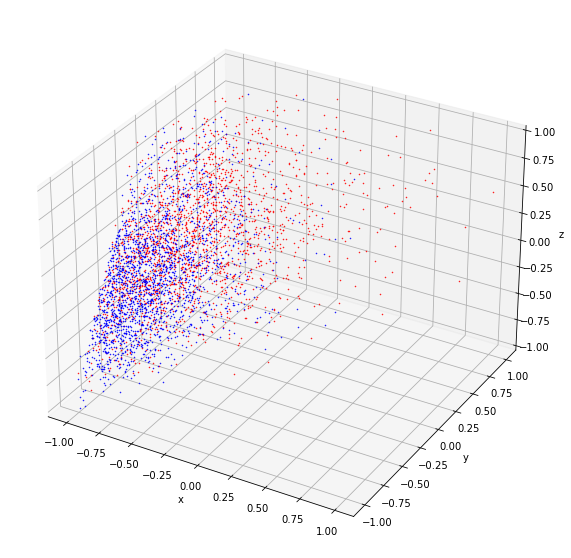

In [19]:
quantum_hw = 1

theta_best = [6.26587362 ,0.48170071, 5.83294853, 6.91784118, 5.66748716, 3.21408443, 7.48266962, 2.8317172 , 0.62089649, 4.52903473 ,7.28424979, 4.19127836]
# data1 = pickle.load(open("VBS_part1.pkl","rb"))
# Ind = data1.columns


X1 = np.array(data1[Ind[ii]])
X2 = np.array(data2[Ind[ii]])

X = []
for i in range(start + number_training, start + number_training + number_testing):
    X.append(X1[i])
    X.append(X2[i])

#X are normalizated over [-1,1]
if Xmax-Xmin!= 0:
    X = (np.array(X)- Xmin)*2/(Xmax-Xmin)
X = np.array(X) -1
#X = Sqrt(X)
X = np.clip(X,-1,1)

############################################################

Y1 = np.array(data1[Ind[jj]])
Y2 = np.array(data2[Ind[jj]])


Y = []
for i in range(start + number_training, start + number_training + number_testing):
    Y.append(Y1[i])
    Y.append(Y2[i])

#Y are normalizated over [-1,1]
if Ymax-Ymin!= 0:
    Y = (np.array(Y)- Ymin)*2/(Ymax-Ymin)
Y = np.array(Y)-1
Y = Sqrt(Y)
Y = np.clip(Y,-1,1)

############################################################

Z1 = np.array(data1[Ind[kk]])
Z2 = np.array(data2[Ind[kk]])

Z = []
for i in range(start + number_training, start + number_training + number_testing):
    Z.append(Z1[i])
    Z.append(Z2[i])

#Z are normalizated over [-1,1]
if Zmax-Zmin!= 0:
    Z = (np.array(Z)- Zmin)*2/(Zmax-Zmin)
Z = np.array(Z)-1
#Z = Cheb(Z)
Z = Sqrt(Z)
Z = np.clip(Z,-1,1)


X1 = []
X2 = []
Y1 = []
Y2 = []
Z1 = []
Z2 = []

for i in range(0,len(X)):
    if i % 2 == 0:
        X1.append(X[i])
        Y1.append(Y[i])
        Z1.append(Z[i])
    else:
        X2.append(X[i])
        Y2.append(Y[i])
        Z2.append(Z[i])

#TESTING SET VISUALIZATION
if plot_data == 1:
    %matplotlib inline
    fig = plt.figure(figsize = (10,10)) 
    ax = plt.axes(projection='3d')
    ax.plot3D(X1,Y1,Z1,'ro',markersize = 0.5)
    ax.plot3D(X2,Y2,Z2,'bo',markersize = 0.5)
    ax.set_xlabel('x')   
    ax.set_ylabel('y')   
    ax.set_zlabel('z')  

#### Preparing for testing

In [20]:
N = int(len(X)/max_circuits_supported)

v = np.zeros((N, max_circuits_supported))
for i in range(0,N):
    for j in range(0,max_circuits_supported):
        v[i][j] = X[j+i*max_circuits_supported]
        
remainder = len(X)%max_circuits_supported     
v_last = np.zeros(remainder)
for j in range(0,remainder):
    v_last[j] = X[j+N*max_circuits_supported]

In [21]:
Phi_f = np.zeros((len(X), 2*number_var))
for i in range(0,len(X)):
    for j in range(0, 2*number_var):
        Phi_f[i][j] = Phi_function(X[i],Y[i],Z[i])[j]

In [22]:
f_l = []
for i in range(0,len(X)):
    f_l.append(f_label(i))

#### Testing & AUC

Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
Job Status: job has successfully run
J

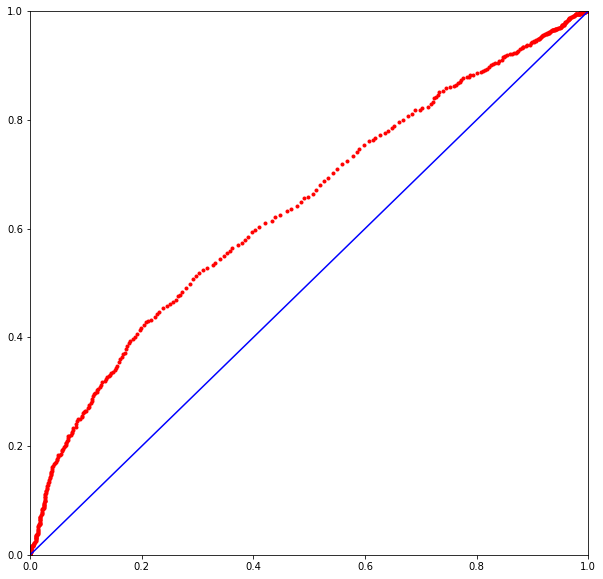

In [23]:
if plot_AUC_image == 1:
    fig2 = plt.figure(figsize = (10,10)) 
    plt.ylim((0,1))
    plt.xlim((0,1))

counts = training_set(theta_best,circuit,theta,Phi_f)

index_sorted = []
classification = []
for i in range(0,len(X)):
    classification.append(f_measuration(counts[i])[0])

sort_index = np.argsort(classification)

Classification = []
Labelling = []
for i in range(0,len(X)):
    Classification.append(f_measuration(counts[sort_index[i]])[0])
    Labelling.append((sort_index[i]+1)%2)

treshold = np.linspace(0,1,1000)
False_positive_rate = []
True_positive_rate = []

for k in range(0,len(treshold)):
    C = Classification > treshold[k]
    false_negatives = sum((Labelling - C) == np.int_(np.ones(len(X))))
    false_positives = sum(np.array(Labelling - C) ==np.int_(-np.ones(len(X))))
    true_positives = sum(Labelling) - false_negatives 
    true_negatives = sum((Labelling) == np.int_(np.zeros(len(X)))) - false_positives

    False_positive_rate.append(false_positives/(false_positives+true_negatives+0.0001))
    True_positive_rate.append(true_positives/(true_positives+false_negatives+0.0001))
    if plot_AUC_image == 1:
        plt.plot(False_positive_rate[k],True_positive_rate[k],'ro',label = "ROC", markersize=3)
        
if plot_AUC_image == 1:    
    plt.plot(treshold,treshold,'b', markersize=3)                  

In [24]:
#RESULTING AUC
#Simple integration of the ROC curve
def sorter(x,y):
    index = np.zeros(len(x))
    for k in range(0,len(x)):
        min = x[k]
        index[k] = k
        for i in range(k,len(x)):
            if x[i] < min:
                index[k] = i
        buffer = x[k] 
        x[k] = x[int(index[k])]
        x[int(index[k])] = buffer
        buffer = y[k] 
        y[k] = y[int(index[k])]
        y[int(index[k])] = buffer
    return x,y
    
False_positive_rate, True_positive_rate = sorter(False_positive_rate, True_positive_rate)

AUC = 0
for k in range(0,len(False_positive_rate)-1):
    AUC += True_positive_rate[k]*(False_positive_rate[k+1]-False_positive_rate[k])

print(AUC)

0.6368466863153304


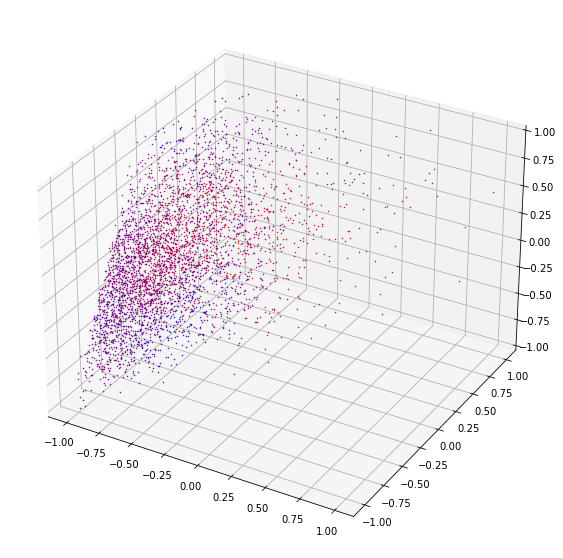

In [25]:
#RESULTING VISUALIZATION
import matplotlib.pyplot as plt
fig = plt.figure(figsize = (10,10)) 
ax = plt.axes(projection='3d')

classificator = []
f_m = []
for i in range(0,len(X)):
    f_m.append(f_measuration(counts[i])[0])

Min = min(f_m)
Max = max(f_m)
delta = Max - Min
    
for i in range(0,len(X)):
    x = [X[i]]
    y = [Y[i]]
    z = [Z[i]]
    ax.plot3D(x,y,z,'o',color = [np.clip((f_measuration(counts[i])[0]-Min)/delta,0,1), 0, np.clip(1-(f_measuration(counts[i])[0]-Min)/delta,0,1)] ,markersize = 0.5)

import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 1000 # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [26]:
#SAVING RESULTS ON A TEXT FILE

file1 = open("real_device_record.txt","a")
FP = str(False_positive_rate).strip('[]')
TP = str(True_positive_rate).strip('[]')
FM = str(f_m).strip('[]')

file1.write("BEGIN ATTEMPT \n\n")
file1.write("number_training = %d \n\n" %number_training)
file1.write("number_testing = %d \n\n" %number_testing)
file1.write("SPSA_steps = %d \n\n" %SPSA_steps)
file1.write("number_var = %d \n\n" %number_var)
file1.write("variables: %d " %ii + "% d " %jj + "%d \n\n" %kk)

file1.write("False Positives: \n\n"+FP+ "\n\n"+"True Positives: \n\n"+TP+ "\n\n"+"f_measuration: \n\n"+FM + "\n\n\n\n\n")
file1.close() 